## The Diffusion Equation

In this assignment, you will find numerical solutions to the diffusion equation.

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


## Part 1 - Dirichlet Boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a Dirichlet boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$M = \pmatrix{
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+2\alpha & \\
}$$

$$b = \pmatrix{
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
}$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

Your code should construct the matrix equation including boundary value term, and solve it using an appropriate linear algebra routine from scipy. You should verify your results, and quantify the uncertainties due to the method.  Discuss your results in the cell below.

In [1]:
import numpy as np
from scipy import stats
from scipy import sparse
from matplotlib import cm
import matplotlib.pyplot as plt

class DiffusionProblem:
    
    """DIFFUSION EQUATION IN 1D WITH THREE DIFFERENT METHODS AND CHI-SQAURE TEST FOR EACH METHOD"""
    
    def __init__(self,t=0.1,h=0.01,thc=59,cond=450,den=7900,L=0.5):
        
        self.L = L                            # Length of poker.               #              
        self.t = t                            # Time step size.                #
        self.h = h                            # Space step size.               #
        self.thc = thc                        # Thermal conductivity of poker. #
        self.cond = cond                      # Specific heat of poker.        #   
        self.den = den                        # Density of poker.              #
        self.k = thc/(den*cond)               # Thermal diffusivity.           #
        self.a = (self.k*self.t)/(self.h**2)  # Matrix coefficient.            #
        self.Nx = int(L/h)                    # Space points.                  #
        
        #*****CREATING THE BASIC MATRICES*****#        
        self.b = np.zeros(self.Nx)
        self.u0 = np.zeros(self.Nx)
        
        #*****CREATING MATRICES FOR IMPLICIT AND EXPLICIT METHODS*****#
        self.m_imp = np.zeros((self.Nx,self.Nx))
        self.m_exp = np.zeros((self.Nx,self.Nx))
        self.I = np.identity(self.Nx)
        
        #*****CREATING DIAGONALS FOR IMPLICIT AND EXPLICIT METHODS*****#
        diag_imp = 1+2*self.a
        diag_exp = 1-2*self.a
        
        #*****FILLING DIAGONAL FOR IMPLICIT AND EXPLICIT METHODS*****#        
        np.fill_diagonal(self.m_imp, diag_imp)
        np.fill_diagonal(self.m_exp, diag_exp)
        
        #*****WILL GENERATE MATRIX SYSTEM FOR EACH METHOD FOR EACH SPACE POINT Nx*****# 
        for i in range(self.Nx-1):
            
            self.m_imp[i+1,i] = -self.a
            self.m_imp[i,i+1] = -self.a
            self.m_exp[i+1,i] =  self.a
            self.m_exp[i,i+1] =  self.a 
            
    #*****DEFINING THE BOUNDARY VALUES OF THE PROBLEM*****#        
    def Boundaries(self,initial,final,d0=1273,dN=273,T0=293,dudx0=0,dudxN=0):
        
        self.u0.fill(T0)

        if initial == 'Dirichlet':
            self.b[0] = -self.a*d0
            
        elif initial == 'Neumann':
            self.m_imp[0,0] -= self.a
            self.m_exp[0,0] += self.a
            self.b[0] = -self.a*self.h*dudx0
        
        if final == 'Dirichlet':
            self.b[-1] = -self.a*dN 
            
        if final == 'Neumann':
            self.m_imp[-1,-1] -= self.a
            self.m_exp[-1,-1] += self.a
            self.b[-1] = -self.a*self.h*dudxN
        
        self.invm_imp = np.linalg.inv(self.m_imp)
        self.crank_imp = self.m_imp + self.I  
        self.crank_exp = self.m_exp + self.I
        
        self.crank_m = np.linalg.inv(self.crank_imp)@self.crank_exp
        self.b_crank = np.linalg.inv(self.crank_imp)@(2*self.b)

    #*****ALLOWS USER TO SOLVE THE SYSTEM WITH THE DESIRED METHOD*****#    
    def Iteration(self,method): 
        
        if method == 'implicit':
            return self.invm_imp@(self.u-self.b)
        
        elif method == 'crank':
            return self.crank_m@self.u-self.b_crank
        
        elif method == 'explicit':
            return self.m_exp@self.u-self.b
          
    #*****SOLVING THE SYSTEM WITH ANY DESIRED METHOD*****#        
    def Calculator(self,iterations,method):
        
        it_method = lambda : self.Iteration(method)   #**Computational time optimisation**#
        
        self.u = np.copy(self.u0)
        v = np.zeros((100,len(self.u)))
        loading = int(iterations/100)    
        j = 0
         
        for i in range(iterations):
                
            self.u = it_method()
            
            if i % loading == 0:
                
                v[j] = np.copy(self.u)
                j += 1
                
        return v
    
    #*****CALCULATES CHI-SQUARE VALUES FOR EVERY STEP*****#
    def Chi_Sqaure_Calculator(self, iterations, method, expected_solution):
        
        it_method = lambda : self.Iteration(method)   #**Computational time optimisation**#  
        self.u = np.copy(self.u0)
        loading = int(iterations/100)    
        chi_square_vals = []       
        
        for i in range(iterations):                
            self.u = it_method()
            
            if i % loading == 0:               
                              
                chi_square_vals.append(stats.chisquare(self.u,expected_solution)[0])
        
        return chi_square_vals
    
#*****PLOTS TEMPERATURE VERSUS POSITION*****#    
def DiffusionPlotter(x,y1,y2,y3,t,dur):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    
    axes[0].plot(x,y1[1], x,y1[9], x,y1[24], x,y1[49])
    axes[0].set_xlabel("Position (m)")
    axes[0].set_ylabel("Temperature (Kelvin)")
    axes[0].legend([str(2*dur*t)+'s',str(10*dur*t)+'s',str(25*dur*t)+'s',str(50*dur*t)+'s'])
    axes[0].set_title("Implicit Method")

    axes[1].plot(x,y2[1], x,y2[9], x,y2[24], x,y2[49])
    axes[1].set_xlabel("Position (m)")
    axes[1].legend([str(2*dur*t)+'s',str(10*dur*t)+'s',str(25*dur*t)+'s',str(50*dur*t)+'s'])
    axes[1].set_title("Explicit Method")

    axes[2].plot(x,y3[1], x,y3[9], x,y3[24], x,y3[49])
    axes[2].set_xlabel("Position (m)")
    axes[2].legend([str(2*dur*t)+'s',str(10*dur*t)+'s',str(25*dur*t)+'s',str(50*dur*t)+'s'])
    axes[2].set_title("Crank-Nicholson")

#*****PLOTS CHI-SQUARE VALUES AGAINST TIME*****#    
def Chi_Square_Plotter(time,y1,y2,y3,t):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    
    axes[0].plot(time, y1)
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Chi-Square")
    axes[0].set_yscale("log")
    axes[0].hlines(y1[-1], 0, time[-1], linestyle='dotted',label='Chi-squared = '+str(y1[-1]), color="r")
    axes[0].legend()
    axes[0].set_title("Implicit Method Chi-Square Test")

    axes[1].plot(time, y2)
    axes[1].set_xlabel("Time (s)")
    axes[1].set_yscale("log")
    axes[1].hlines(y2[-1], 0, time[-1], linestyle='dotted',label='Chi-squared = '+str(y2[-1]), color="r")
    axes[1].legend()
    axes[1].set_title("Explicit Method Chi-Square Test")

    axes[2].plot(time, y3)
    axes[2].set_xlabel("Time (s)")
    axes[2].set_yscale("log")
    axes[2].hlines(y3[-1], 0, time[-1], linestyle='dotted',label='Chi-squared = '+str(y3[-1]), color="r")
    axes[2].legend()
    axes[2].set_title("Crank-Nicholson Chi-Square Test")    

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
1.6354051930292621

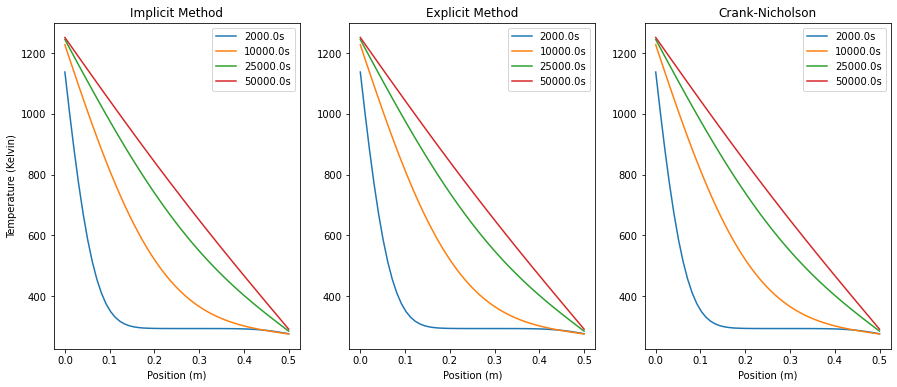

In [2]:
iterations = 100000

oneDrod = DiffusionProblem()
oneDrod.Boundaries(initial ='Dirichlet', final='Dirichlet')

#*****CALCULATING SOLUTIONS FOR DIRICHLET BOUNDARY CONDITIONS*****#

v_imp = oneDrod.Calculator(iterations, 'implicit')
v_exp = oneDrod.Calculator(iterations, 'explicit')
v_crank = oneDrod.Calculator(iterations, 'crank' )
x = np.linspace(0,oneDrod.L,num=len(oneDrod.u))

DiffusionPlotter(x,v_imp,v_exp,v_crank,oneDrod.t, dur=10000)

#*****CALCULATING CHI-SQUARE VALUES FOR DIRICHLET BOUNDARY CONDITIONS*****#

expected_solution = np.linspace(1273, 273, int(oneDrod.Nx))
time = np.linspace(0, iterations*oneDrod.t, num = 100)

chi_square1 = oneDrod.Chi_Sqaure_Calculator(iterations, 'implicit', expected_solution = expected_solution)
chi_square2 = oneDrod.Chi_Sqaure_Calculator(iterations, 'explicit', expected_solution = expected_solution)
chi_square3 = oneDrod.Chi_Sqaure_Calculator(iterations, 'crank', expected_solution = expected_solution)

Chi_Square_Plotter(time, chi_square1, chi_square2, chi_square3, oneDrod.t)

## First Part of the Assignment - Dirichlet Boundary Conditions

### Implicit Method

The matrix equation described in the assignment can be rearanged to $Mu^{n+1} = u^n - b$ and implementing the difinitions for the Dirichlet boundary conditions as part of the first requirement of the assignment. This matrix equation was incorporated into the algorithm by creating a sparse compressed row matrix $M$ by making use of the SciPy library. More specifically the method $\textbf{scipy.sparse.linalg.spsolve}$ was used for each timestep.

The form of the solution at equilibrium was found to be a straight line, connecting the $T_{hot}$ and $T_{cold}$ ends of the poker. To test the accuracy of the equilibrium solution the Chi-Squared value between the expected equilibrium solution of a straight line and that of the simulation was calculated. Further discussion relevant to this accuracy test follows later on.

### Explicit method

Again, by taking the heat equation, the explicit method takes the regions which are close to each other in the previous time steps to calculate the next time steps. This can be expressed in finite steps: 
$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n} - 2u_i^{n} + u_{i-1}^{n}}{h^2}$$
which by rearanging can be expressed as:
$$u_i^{n+1} = \alpha u_{i-1}^{n} + (1 - 2\alpha) u_i^{n}  + \alpha u_{i+1}^{n}$$
where $\alpha$ is the same definition as before.
Dirichlet boundary conditions are applied about the end point to keep $u_N = d_N $ fixed giving:
$$u_i^{n+1} =  \alpha u_{N-2}^{n} + (1 - 2\alpha) u_{N-1}^{n}  + \alpha d_{N}$$
Now it is straight forward enough to write the matrix equation with Dirichlet boundary conditions can as: 

$ u^{n+1} = M_{e}u^n - b $

where $b$ is the same as in the implicit method and $M_e$ a matrix of the form:

$$M = \pmatrix{
1-2\alpha & \alpha   &           &           \\
\alpha   & 1-2\alpha & \alpha   &           \\
          & \alpha   & 1-2\alpha     
}$$

Finally it is written as a sparse matrix and multiplied by $u$ with the boundaries and $b$ subtracted at every time step. The explicit method also provides a solution to equilibrium and is also tested with the Chi-Square test as discussed below.

### Crank-Nicholson Method

The Crank-Nicholson scheme utilises both the values of neighboring sections in the previous and the subsequent time steps, combination of the implicit and explicit methods. Essentially it is the sum of the implicit and explicit finite differences given by:
$$\frac{u_i^{n+1} - u_i^n}{\tau} = \frac{k}{2} \frac{(u_{i+1}^{n} - 2u_i^{n} + u_{i-1}^{n}) +(u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}) }{h^2}$$
which can be re-expressed as:
$$- \alpha u_{i-1}^{n+1} + (2 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1} = \alpha u_{i-1}^{n} + (2 - 2\alpha) u_i^{n}  + \alpha u_{i+1}^{n}$$
Initialising Dirichlet boundary conditions, retaining $u_N^{n+1} = u_N^{n} = d_N$ and rearanging we obtain the following matric form:
$$ M_{c1} u^{n+1} = M_{c2}u^n - 2b $$
where $b$ is defined as in the implicit and explicit methods and $M_{c1}$ and $M_{c2}$ follow the forms:

$$M_{c1} = \pmatrix{
2+2\alpha & -\alpha   &           &           \\
-\alpha   & 2+2\alpha & -\alpha   &           \\
          & -\alpha   & 2+2\alpha     }
\;\;\;\;\; M_{c2} = \pmatrix{
2-2\alpha & \alpha   &           &           \\
\alpha   & 2-2\alpha & \alpha   &           \\
          & \alpha   & 2-2\alpha     }$$
          
The developed algorithm classifies these matrices as sparse matrices and the matrix equation is solved at each timestep using the SciPy sparse methods as instructed in the Iteration() function of the relevant class.

Similar results to the implicit method were observed which were also tested using the Chi-Square test as discussed below.

### Testing the Accuracy of results with the  Chi-Squared statistical method

The test the accuracy of the solutions obtained by all three methods, for both Dirichlet and Neumann conditions, they were compared to the equilibrium solution for every time step. This was achieved by calculating the Chi-Squared value of the generated data versus the expected expected data at equilibrium. The Chi-Squared values are given by: 
$$ \chi^2 = \sum_{i}^{N} \frac{(O_i - E_i)^2}{E_i} $$

where $O_i$ is the observed value and $E_i$ is the expected value, both of them being at equilibrium. It is theoretically expected that a larger number of iterations leads to the solution converging to the equilibrium solution better.

For both the Dirichlet and Neumann boundary conditions it was found that the accuracy of the calculation reaches a maximum at a certain Chi-Squared value and the calculation does not converge any closer to the equilibrium even by increasing the number of iterations. But the limit of the Chi-Squared value and hence accuracy is dynamic. As a matter of fact, the stability of the explicit method depends on the value $h$ (spacial step). It is worth mentioning that the accuracy heavily depends on the division between the time step and spacial step.

The Chi-Square values obtained for the Implicit, Explicit and Crank-Nicholson methods, for both Dirichlet and Neumann conditions where all around 11.67 suggesting that the present algorithm implementation is considerably accurate. Much higher accuracy (Chi-Squared=1.35) was achieved by increasing the spacial step $\textbf{(accuracy depends on the division of time step with spacial step)}$ which resulted in a considerably longer amount of time for the generation of data. In the present discussion, the Chi-Square test for a reasonable time step is presented. 

## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the tempeterature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two noces have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$M = \pmatrix{
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
}$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
1.6354051930292621

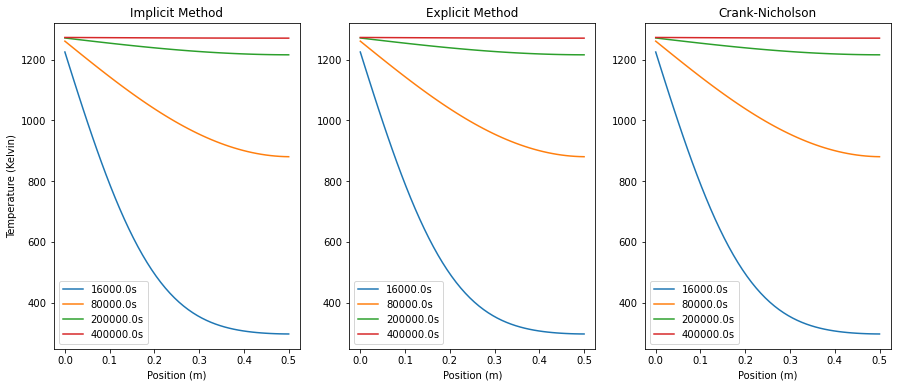

In [3]:
iterations = 800000

oneDrod2 = DiffusionProblem()
oneDrod2.Boundaries(initial='Dirichlet', final='Neumann')

#*****CALCULATING SOLUTIONS FOR NEUMANN BOUNDARY CONDITIONS*****#

v_imp2 = oneDrod2.Calculator(iterations, 'implicit')
v_exp2 = oneDrod2.Calculator(iterations, 'explicit')
v_crank2 = oneDrod2.Calculator(iterations, 'crank')
x2 = np.linspace(0,oneDrod2.L,num=len(oneDrod2.u))

DiffusionPlotter(x,v_imp2,v_exp2,v_crank2,oneDrod2.t, dur=80000)

#*****CALCULATING CHI-SQAURE VALUES FOR NEUMANN BOUNDARY CONDITIONS*****#

expected_solution2 = np.linspace(1273, 273, int(oneDrod2.Nx))
time2 = np.linspace(0, iterations*oneDrod2.t, num = 100)

chi_square1_D = oneDrod.Chi_Sqaure_Calculator(iterations, 'implicit', expected_solution = expected_solution2)
chi_square2_D = oneDrod.Chi_Sqaure_Calculator(iterations, 'explicit', expected_solution = expected_solution2)
chi_square3_D = oneDrod.Chi_Sqaure_Calculator(iterations, 'crank', expected_solution = expected_solution2)

Chi_Square_Plotter(time2, chi_square1_D, chi_square2_D, chi_square3_D, oneDrod2.t)

## Second part of the Assignment - Neumann Boundary Conditions

### Implicit Method
The same SciPy routine that was described above was applied, this time changing the boundary conditions as required by the assignment. The expected solution was obtained. The poker heated up slowly until it reached 1273 degrees Kelvin. The accuracy of the obtained results was evaluated with the Chi-squared method and it showed the same accuracy as for the Dirichlet conditions. After all the computational complexity and general approach is the same, with the difference being the boundary conditions. If the algorithm is allowed to run for a sufficiently long time it will be observed than the whole poker reaches a temperature of 1273 Kelvin.

### Explicit method

Applying the Neumann boundary condition of $\frac{\partial u}{\partial x} = 0$ at the end resulted in $u^{n}_{N} = u^{n}_{N-1}$ as earlier. By substituting this into the Nth element results in:
$$u^{n+1}_{N-1} = \alpha u^{n}_{N-2} + (1 - \alpha)u^{n}_{N-1}$$
revealing that the last element of the diagonal of the explicit matrix had to be replaced by $1 - \alpha$.

As a result the heat equation was successfully simulated for the Neumann boundary conditions. The equilibrium position was reached just like in the implicit method.

### Crank-Nicholson method

The Neumann boundary condition for the Crank-Nicholson method was identical to the explicit and implicit method but the last entries of the matrices $M_{c1}$ and $M_{c2}$ were replaced with $2 + \alpha$ and $2 - \alpha$ respectively.

Similar results to the implicit and explicit method were obtained. 

In [4]:
class ADI_Method_2D:
    
    """DIFFUSION EQUATION IN 2D WITH NO-FLUX BOUNDARY CONDITION USING THE
       ADI (ALTERNATING-DIRECTION-IMPLICIT) METHOD. SIMULATES THE TEMPERA
       TURE EVOLUTION OF A SQUARE METAL SHEET WHOSE CORNERS ARE HELD AT 0
       TEMPERATURE. A SPHERICAL HEAT DISTIRBUTION IS APPLIED TO ITS CENTR
       E. TEMPERATURE IS NORMALISED."""
    
    def __init__(self, M, time_duration, D):
         
        self.M = M                             # Grid dimensions.                                      #
        self.x0 = 0                            # Initial condition at edge x0.                         #
        self.xf = 1                            # Initial condition at edge xf.                         #
        self.y0 = 0                            # Initial condition at edge y0.                         #
        self.yf = 1                            # Initial condition at edge yf.                         #
        self.time_duration = time_duration     # Snapshot of temperature evolution at a specific time. #
        self.dt = 0.01                         # Time step.                                            #
        self.D = D                             # Diffusion coefficient.                                #
        self.h = 1/self.M                      # Spacial step.                                         #
        self.r = self.D*self.dt/(2*self.h**2)  # Circular heat distribution applied to square plane.   #                                                      #
        self.Grid_Generator()                  # Function which generates grid.                        #
        self.LHS_Matrix_A()                    # Function which generates LHS matrix.                  #
        self.RHS_Matrix_A()                    # Function which generates RHS matrix.                  #

#*****GENERATES A GRID WITH X,Y,U AXES TO STORE DATA AND VISUALIZE IT LATER ON*****#        
    def Grid_Generator(self):
        
        self.X, self.Y = np.meshgrid(np.linspace(self.x0, self.xf, self.M), np.linspace(self.y0, self.yf,self. M))
        IC_01 = np.logical_and(self.X >= 1/4, self.X <= 3/4)
        IC_02 = np.logical_and(self.Y >= 1/4, self.Y <= 3/4)
        IC_0 = np.multiply(IC_01, IC_02)
        self.U = IC_0*1

#*****CREATING THE LEFT HAND SIDE MATRIX OF THE SYSTEM*****#        
    def LHS_Matrix_A(self):
        
        main_diagonal = (1+2*self.r)*np.ones((1, self.M))
        off_diagonal = -self.r*np.ones((1, self.M-1))
        a = main_diagonal.shape[1]
        diagonals = [main_diagonal, off_diagonal, off_diagonal]
        Lx = sparse.diags(diagonals, [0, -1, 1], shape=(a, a)).toarray()
        Ix = sparse.identity(self.M).toarray()
        self.A = sparse.kron(Ix, Lx).toarray()
        
        position_1 = np.arange(0,self.M**2,self.M)
        
        for i in range(len(position_1)):
            self.A[position_1[i], position_1[i]] = 1 + self.r
            
        position_2 = np.arange(self.M-1, self.M**2, self.M)
        
        for j in range(len(position_2)):
            self.A[position_2[j], position_2[j]] = 1 + self.r

#*****CREATING THE RIGHT HAND SIDE MATRIX OF THE SYSTEM*****#
    def RHS_Matrix_A(self):
        
        main_diagonal = (1-self.r)*np.ones((1, self.M))
        off_diagonal = self.r*np.ones((1, self.M-1))
        a = main_diagonal.shape[1]
        diagonals = [main_diagonal, off_diagonal, off_diagonal]
        Rx = sparse.diags(diagonals, [0, -1, 1], shape=(a, a)).toarray()
        Ix = sparse.identity(self.M).toarray()
        self.A_RHS = sparse.kron(Rx, Ix).toarray()
        
        position_3 = np.arange(self.M, self.M**2-self.M)
        
        for k in range(len(position_3)):
            self.A_RHS[position_3[k], position_3[k]] = 1 - 2*self.r
            
#*****SOLVING THE 2D SYSTEM WITH THE ADI METHOD*****#            
    def Calculator_2D(self):
        tc = 0
        nstep = round(self.time_duration/self.h)
        
        while tc < nstep:
            
            b1 = np.flipud(self.U).reshape(self.M**2, 1)
            sol = np.linalg.solve(self.A, np.matmul(self.A_RHS, b1))
            self.U = np.flipud(sol).reshape(self.M, self.M)
            
            b2 = np.flipud(self.U).reshape(self.M**2, 1)
            sol = np.linalg.solve(self.A, np.matmul(self.A_RHS, b2))
            self.U = np.flipud(sol).reshape(self.M, self.M)
            tc += 1        

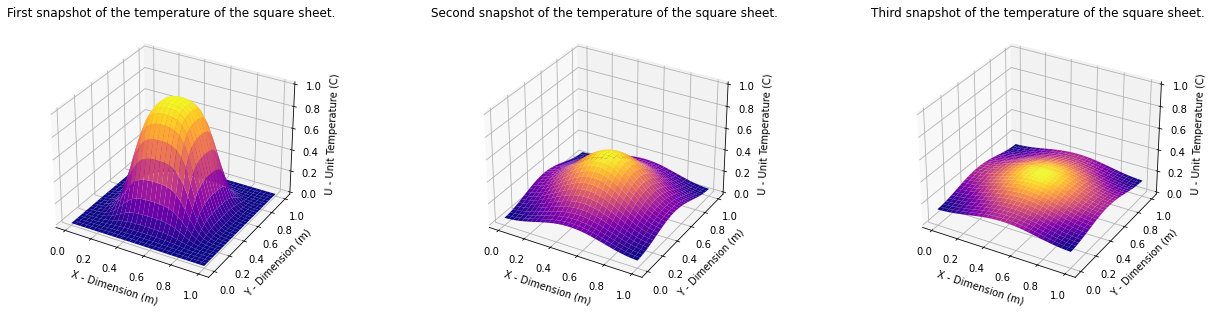

In [5]:
"""VARIABLES SIM1, SIM2 AND SIM3 BELOW ARE CALLING THE CLASS TO GENERATE DATA
   AT DIFFERENT EPOCHS OF THE TEMPERATURE EVOLUTION OF THE SQUARE PLATE.AFTER
   THE DATA FOR EACH EPOCH IS GENERATED, IT IS PLOTTED WITHOUT ANY COMPLICATIONS"""

sim1 = ADI_Method_2D(30, 1, 0.01)
sim1.Calculator_2D()

sim2 = ADI_Method_2D(30, 8, 0.01)
sim2.Calculator_2D()

sim3 = ADI_Method_2D(30, 15, 0.01)
sim3.Calculator_2D()

fig =  plt.figure(figsize=(22,5))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(sim1.X, sim1.Y, sim1.U, cmap=cm.plasma, linewidth=0, antialiased=True)
ax.set_zlim(0,1)
ax.set_title('First snapshot of the temperature of the square sheet.')
ax.set_xlabel('X - Dimension (m)')
ax.set_ylabel('Y - Dimension (m)')
ax.set_zlabel('U - Unit Temperature (C)')

ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.plot_surface(sim2.X, sim2.Y, sim2.U, cmap=cm.plasma, linewidth=0, antialiased=True)
ax1.set_zlim(0,1)
ax1.set_title('Second snapshot of the temperature of the square sheet.')
ax1.set_xlabel('X - Dimension (m)')
ax1.set_ylabel('Y - Dimension (m)')
ax1.set_zlabel('U - Unit Temperature (C)')
                       
ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.plot_surface(sim3.X, sim3.Y, sim3.U, cmap=cm.plasma, linewidth=0, antialiased=True)
ax2.set_zlim(0,1)
ax2.set_title('Third snapshot of the temperature of the square sheet.')
ax2.set_xlabel('X - Dimension (m)')
ax2.set_ylabel('Y - Dimension (m)')
ax2.set_zlabel('U - Unit Temperature (C)')

plt.show()

## THE 2D DIFFUSION EQUATION

The diffusion equation in 2 dimensions is described by a linear partial differential equation of the form:
$$
\frac{\partial \phi(\mathbf{r}, t)}{\partial t}=D \nabla^{2} \phi(\mathbf{r}, t)
$$
which utilises the Laplace differential operator and where $D$ is the diffusion coefficient. There are various ways to numerically solve this type of partial differential eqaution, however, in this algorithm the ADI scheme is utilised.

### Alternating-Direction Implicit (ADI) Scheme

The ADI scheme provides a two step general for solving parabolic equations in 2 spatial dimensions using tri-diagonal matrices. It is a two step method because because each time increment is executed in two steps, the first being explicit and the second being implicit.

The 2D diffusion equation, $u_{t}=D \nabla^{2} u$ may be approximated by:
$$
\frac{U_{i, j}^{k+\frac{1}{2}}-U_{i, j}^{k}}{\Delta t / 2}=D\left(\frac{U_{i+1, j}^{k}-2 U_{i, j}^{k}+U_{i-1, j}^{k}}{\Delta x^{2}}+\frac{U_{i, j+1}^{k+\frac{1}{2}}-2 U_{i, j}^{k+\frac{1}{2}}+U_{i, j-1}^{k+\frac{1}{2}}}{\Delta y^{2}}\right)
$$
and by letting $\Delta x$=$\Delta y$=$h$ and $r=\frac{\Delta t D}{2 h^{2}}$ we obtain:
$$
-r U_{i, j-1}^{k+\frac{1}{2}}+(1+2 r) U_{i, j}^{k+\frac{1}{2}}-r U_{i, j+1}^{k+\frac{1}{2}}=r U_{i-1, j}^{k}+(1-2 r) U_{i, j}^{k}+r U_{i+1, j}^{k}
$$
which is the explicit expression.

In the second step, from $t^{k+\frac{1}{2}}$ to $t^{k+1}$ the previous equation is approximated by:
$$
\frac{U_{i, j}^{k+1}-U_{i, j}^{k+\frac{1}{2}}}{\Delta t / 2}=D\left(\frac{U_{i+1, j}^{k+1}-2 U_{i, j}^{k+1}+U_{i-1, j}^{k+1}}{h^{2}}+\frac{U_{i, j+1}^{k+\frac{1}{2}}-2 U_{i, j}^{k+\frac{1}{2}}+U_{i, j-1}^{k+\frac{1}{2}}}{h^{2}}\right)
$$
which transforms into:
$$
-r U_{i-1, j}^{k+1}+(1+2 r) U_{i, j}^{k+1}-r U_{i+1, j}^{k+1}=r U_{i, j-1}^{k+\frac{1}{2}}+(1-2 r) U_{i, j}^{k+\frac{1}{2}}+r U_{i, j+1}^{k+\frac{1}{2}}
$$
by rearranging. This last expression is implicit.

The developed algorithm and more specifically class $\textbf{ADI_Method_2D}$ first solves the explicit eqaution and then the implicit equation defined above by utilised the functions included in it. 

To solve equation the explicit equation it fixes $i=1,2, \ldots, M-1$ and solves a tridiagonal system to get $U_{i, j}^{k+\frac{1}{2}}$ for $j=1,2, \ldots, N-1$.

Finally, to solve the implicit equation it fixes $j=1,2, \ldots, N-1$ and solves a tridiagonal system to get $U_{i, j}^{k+1}$ for $i=1,2, \ldots, M-1$.

### RESULTS 

It is worth mentioning that the algorithm simulates the diffusion equation applied to a square metal plate initially at temperature $T_{cold}=0$ apart from a circular disc of a specified size which is at temperature $T_{hot}=1$. The edges of the plate are held fixed at $T_{cool}=0$, meaning that their temperature will always remain unchanged at $T_{cold}=0$. The developed algorithm applies the above formula to follow the evolution of the temperature of the square metal plate.

To demonstrate the evolution of the heat distribution overtime three different epochs were visualized, starting from the earliest and ending at the latest. The responsible class for this operation was called three times, each time by changing the time parameter. This enabled the generation of data for different epochs and their visualisation.

The fact the heat distirbution is circular (due to the circular disc in close proximity to the square metal sheet) is accurately illustrated in the generated 3D plots. It is observed that initially the peak has a circular shape with the peak being much more intense as it is closer to the hot circular disc. Overtime, it is observed that the peak does not change position in the 2d plane, however, its height, or the normalised temperature decreases as heat spreads across the surface area of the square metal plate. 

The diffusion coefficient D, by definition describes how efficiently thermal energy is dissipated over the surface of the square plate. Both a very large diffusion coefficient and a very small diffusion coefficient would result in the same spread, however the latter would do so much faster. The behaviour observed in all of the 3D plots confirms these assumptions as the heat distribution remains circular and overtime we see that the heat spreads out evenly over the square metal plate, with its edges remaining at $T_{cold}=0$ as expected theoretically. 

### SCOPE OF THE 2D DIFFUSION EQUATION SIMULATION

The simulation of the 2D diffusion equation is part of an extension to the original assignment and aims to primarily represent how the ADI method works and secondly to describe how the diffusion coefficient influences thermal energy dissipation. It is very important to stress out this simulation only describes the temperature evolution of a square metal plate which is in close proximity with a circular disk of high temperatue. The edges of the square area held at temperature zero whereas the circular disk is at temperature one. The temperature has been normalised and is given in Celsius. 


### REFERENCES 

1) Peaceman, D. W.; Rachford Jr., H. H. (1955), "The numerical solution of parabolic and elliptic differential equations", Journal of the Society for Industrial and Applied Mathematics, 3 (1): 28–41

2) Chang, M. J.; Chow, L. C.; Chang, W. S. (1991), "Improved alternating-direction implicit method for solving transient three-dimensional heat diffusion problems", Numerical Heat Transfer, Part B: Fundamentals, 19 (1): 69–84

3) Thambynayagam, R. K. M (2011). The Diffusion Handbook: Applied Solutions for Engineers.

4) Carslaw, H. S. and Jaeger, J. C. (1959). Conduction of Heat in Solids. Oxford: Clarendon Press

5) Crank, J. (1956). The Mathematics of Diffusion. Oxford: Clarendon Press